# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

In [4]:
# Setup cell.
import numpy as np
import matplotlib.pyplot as plt
from dl_utils.fc_net import *
from dl_utils.data_utils import get_CIFAR10_data
from dl_utils.gradient_check import eval_numerical_gradient
from dl_utils.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check
Read through the `FullyConnectedNet` class in the file `sources/fc_net.py`. Ignore dropout or batch/layer normalization.

Implement the network initialization, forward pass, and backward pass. This time you will implement layers in `sources/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from ''2.two_layer_net''.

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.409028728052923e-08
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.131129859578198e-08
b1 relative error: 1.4752427965311745e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.976427
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.133000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.103000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.132000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.147000
(Epoch 4 / 20) train acc: 0.600000; val_acc: 0.160000
(Epoch 5 / 20) train acc: 0.960000; val_acc: 0.162000
(Iteration 11 / 40) loss: 0.491858
(Epoch 6 / 20) train acc: 0.920000; val_acc: 0.166000
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.174000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.188000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.181000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.183000
(Iteration 21 / 40) loss: 0.151649
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.183000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.187000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.183000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.190000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.187000
(Iteration 31 / 40) loss: 

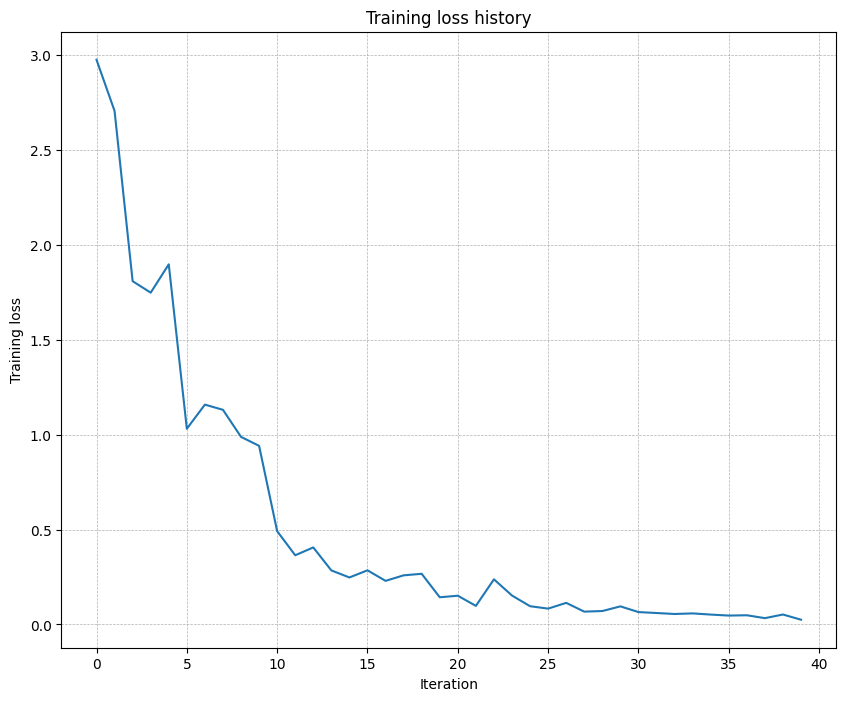

In [38]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

weight_scale = 20e-3   # Experiment with this!
learning_rate = 40e-4  # Experiment with this!

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

You are likely to see that the _five-layer_ network is more sensible to initialization scale than the _three-layer_ one.

(Iteration 1 / 40) loss: 3.606974
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.100000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.119000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.128000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.119000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.106000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.132000
(Iteration 11 / 40) loss: 0.597281
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.137000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.135000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.132000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.138000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.146000
(Iteration 21 / 40) loss: 0.418960
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.127000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.134000
(Iteration 31 / 40) loss: 

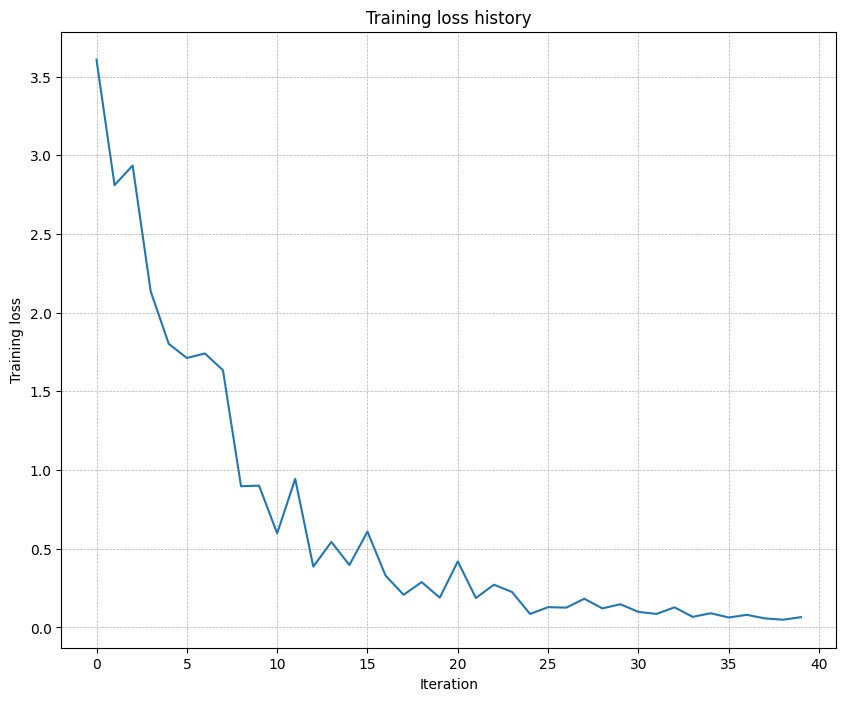

In [35]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

weight_scale = 5e-2   # Experiment with this!
learning_rate = 41e-4  # Experiment with this!

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Open the file `sources/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [ ]:
from dl_utils.optim import sgd_momentum
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579,  0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.859417
(Epoch 0 / 5) train acc: 0.096000; val_acc: 0.106000
(Iteration 11 / 200) loss: 2.297712
(Iteration 21 / 200) loss: 2.213687
(Iteration 31 / 200) loss: 2.165669
(Epoch 1 / 5) train acc: 0.241000; val_acc: 0.225000
(Iteration 41 / 200) loss: 2.079713
(Iteration 51 / 200) loss: 2.038937
(Iteration 61 / 200) loss: 1.993093
(Iteration 71 / 200) loss: 2.014225
(Epoch 2 / 5) train acc: 0.259000; val_acc: 0.285000
(Iteration 81 / 200) loss: 1.908163
(Iteration 91 / 200) loss: 1.959224
(Iteration 101 / 200) loss: 1.841330
(Iteration 111 / 200) loss: 1.910850
(Epoch 3 / 5) train acc: 0.320000; val_acc: 0.301000
(Iteration 121 / 200) loss: 1.846665
(Iteration 131 / 200) loss: 1.872122
(Iteration 141 / 200) loss: 1.821684
(Iteration 151 / 200) loss: 1.925978
(Epoch 4 / 5) train acc: 0.339000; val_acc: 0.303000
(Iteration 161 / 200) loss: 1.889614
(Iteration 171 / 200) loss: 1.663118
(Iteration 181 / 200) loss: 1.895356
(Iteration 191 / 200) los

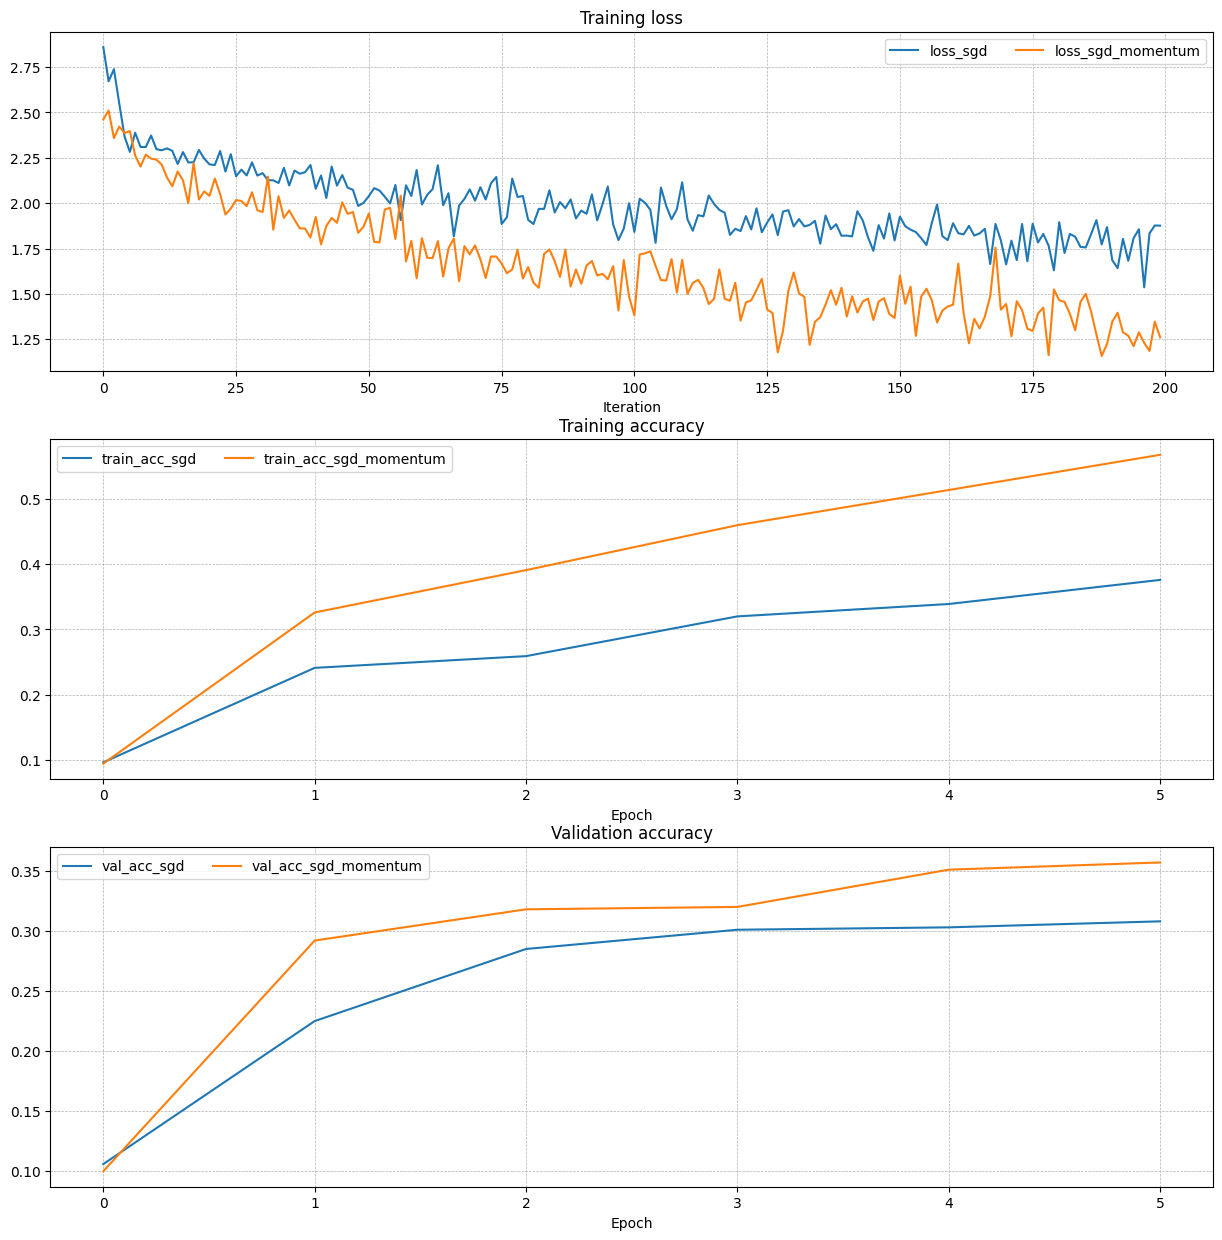

In [76]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `sources/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [79]:
# Test RMSProp implementation
from dl_utils.optim import rmsprop
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [80]:
# Test Adam implementation
from dl_utils.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.623124
(Epoch 0 / 5) train acc: 0.156000; val_acc: 0.147000
(Iteration 11 / 200) loss: 1.999823
(Iteration 21 / 200) loss: 1.846237
(Iteration 31 / 200) loss: 1.684066
(Epoch 1 / 5) train acc: 0.347000; val_acc: 0.335000
(Iteration 41 / 200) loss: 1.543071
(Iteration 51 / 200) loss: 1.801047
(Iteration 61 / 200) loss: 1.713412
(Iteration 71 / 200) loss: 1.573716
(Epoch 2 / 5) train acc: 0.433000; val_acc: 0.354000
(Iteration 81 / 200) loss: 1.601229
(Iteration 91 / 200) loss: 1.546967
(Iteration 101 / 200) loss: 1.637101
(Iteration 111 / 200) loss: 1.615425
(Epoch 3 / 5) train acc: 0.522000; val_acc: 0.358000
(Iteration 121 / 200) loss: 1.389586
(Iteration 131 / 200) loss: 1.216087
(Iteration 141 / 200) loss: 1.404540
(Iteration 151 / 200) loss: 1.280975
(Epoch 4 / 5) train acc: 0.542000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.412320
(Iteration 171 / 200) loss: 1.107331
(Iteration 181 / 200) loss: 1.475813
(Iteration 191 / 200) lo

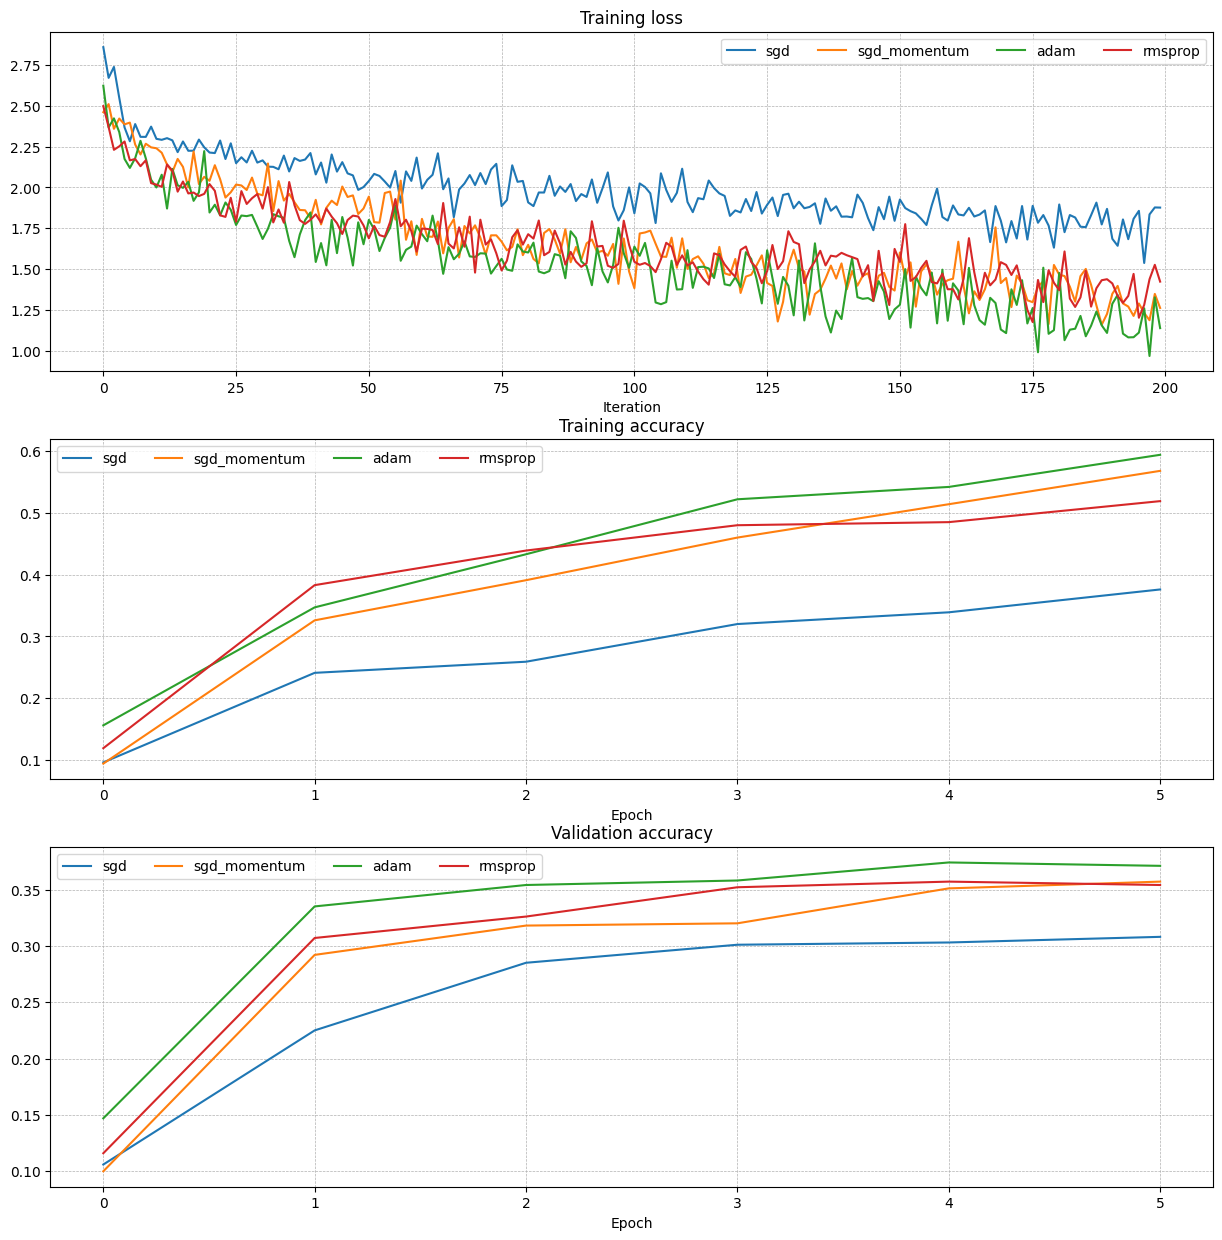

In [82]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()